# Evaluating causal metrics

In [21]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets
import torchvision.models as models
from torch.nn.functional import conv2d
from ipywidgets import interact, IntSlider, fixed
from utils import *
from evaluation import CausalMetric, auc, gkern
from explanations import RISE

cudnn.benchmark = True

In [22]:
# Load black box model for explanations
model = models.resnet50(True)
model = nn.Sequential(model, nn.Softmax(dim=1))
model = model.eval()
model = model.cuda()

for p in model.parameters():
    p.requires_grad = False
    
# To use multiple GPUs
model = nn.DataParallel(model)

## Preparing substrate functions

For our causal metrics we need functions that define how we delete/insert pixels. Specifically, we define mapping from old pixels to new pixels. We use zero substrate for deletion and blurred image substrate for insertion.

In [23]:
klen = 11
ksig = 5
kern = gkern(klen, ksig)

# Function that blurs input image
blur = lambda x: nn.functional.conv2d(x, kern, padding=klen//2)

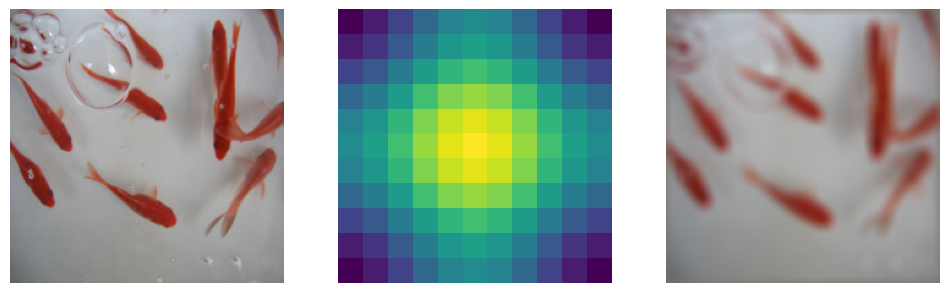

In [24]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.axis('off')
img = read_tensor('goldfish.jpg')
tensor_imshow(img[0])

plt.subplot(132)
plt.axis('off')
plt.imshow(kern[0, 0])

plt.subplot(133)
plt.axis('off')
tensor_imshow(blur(img)[0])
plt.show()

## Creating metrics and explainer instances

In [25]:
insertion = CausalMetric(model, 'ins', 224, substrate_fn=blur)
deletion = CausalMetric(model, 'del', 224, substrate_fn=torch.zeros_like)

In [26]:
explainer = RISE(model, (224, 224))
explainer.generate_masks(N=2000, s=10, p1=0.1)

Generating filters: 100%|██████████| 2000/2000 [00:02<00:00, 953.37it/s]


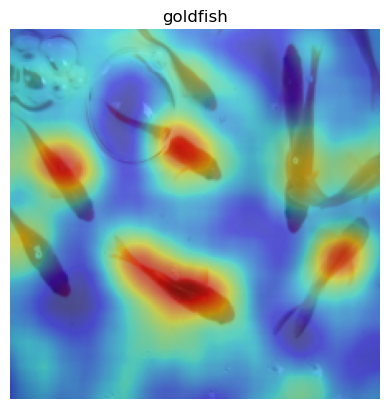

In [27]:
# 1 is for 'goldfish' class
sal = explainer(img.cuda())[1].cpu().numpy()

tensor_imshow(img[0])
plt.axis('off')
plt.title(get_class_name(1))
plt.imshow(sal, cmap='jet', alpha=0.5)
plt.show()

## Evaluating metrics for a single image

Image on the left is the final image in the **deletion** process. It's an all-zero image for the network. It is gray instead of black, because we are setting pixels to $0$ in the space of normalized images. So after denormalization it becomes equal to the ImageNet mean which is $[0.485, 0.456, 0.406]$.

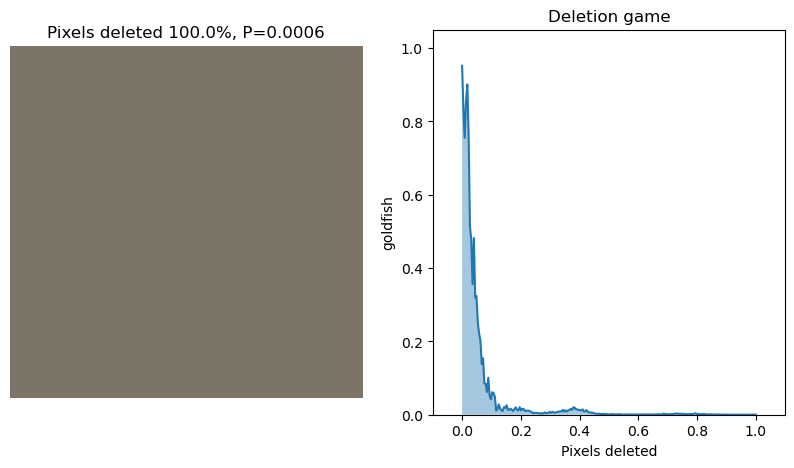

In [28]:
h = deletion.single_run(img, sal, verbose=1)

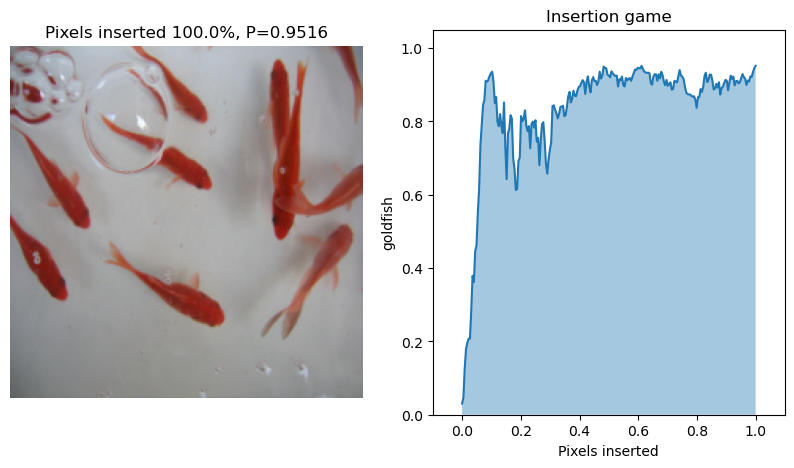

In [29]:
h = insertion.single_run(img, sal, verbose=1)

## Qualitative and quantitative comparison of RISE, LIME and GradCAM

In [30]:
batch = 4
# Load saved explanations
gc = np.fromfile('../random-masking/gradcam/gc(resnet)_{:05}-{:05}'.format(batch*5000, (batch+1)*5000-1)).reshape((5000, 224, 224))
rm = np.fromfile('../random-masking/run02/explanations/exp_{:05}-{:05}.npy'.format(batch*5000, (batch+1)*5000-1)).reshape((5000, 224, 224))
li = np.fromfile('../random-masking/lime/lime_{:05}-{:05}.npy'.format((batch+1)*5000-2, (batch+1)*5000-1)).reshape((5000, 224, 224))

# Load images
dataset = datasets.ImageFolder('/scratch2/Datasets/imagenet/ILSVRC2012_val_folders/', preprocess)
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=250, shuffle=False,
    num_workers=8, pin_memory=True, sampler=RangeSampler(range(5000*batch, 5000*(batch+1))))

images = np.empty((len(data_loader), 250, 3, 224, 224))
for j, (img, _) in enumerate(tqdm(data_loader, total=len(data_loader), desc='Loading images')):
    images[j] = img
images = images.reshape((-1, 3, 224, 224))

FileNotFoundError: [Errno 2] No such file or directory: '../random-masking/gradcam/gc(resnet)_20000-24999'

In [ ]:
def show_i(j, gc, rm, li, images):
    plt.figure(figsize=(20, 5))
    
    plt.subplot(141)
    plt.axis('off')
    p, c = torch.topk(model(torch.from_numpy(images[j:j+1]).float()), 1)
    plt.title('{}: {:.1f}%'.format(get_class_name(c), 100 * float(p)))
    tensor_imshow(torch.from_numpy(images[j:j+1])[0])
    
    plt.subplot(142)
    plt.axis('off')
    tensor_imshow(torch.from_numpy(images[j:j+1])[0])
    plt.imshow(rm[j], alpha=0.5, cmap='jet')
    sc1d = auc(deletion.single_run(torch.from_numpy(images[j:j+1].astype('float32')), rm[j]))
    sc1i = auc(insertion.single_run(torch.from_numpy(images[j:j+1].astype('float32')), rm[j]))
    plt.title('RISE: {:.3f} / {:.3f}'.format(sc1d, sc1i))
    
    plt.subplot(143)
    plt.axis('off')
    tensor_imshow(torch.from_numpy(images[j:j+1])[0])
    plt.imshow(li[j], alpha=0.5, cmap='jet')
    sc2d = auc(deletion.single_run(torch.from_numpy(images[j:j+1].astype('float32')), li[j]))
    sc2i = auc(insertion.single_run(torch.from_numpy(images[j:j+1].astype('float32')), li[j]))
    plt.title('LIME: {:.3f} / {:.3f}'.format(sc2d, sc2i))
    
    plt.subplot(144)
    plt.axis('off')
    tensor_imshow(torch.from_numpy(images[j:j+1])[0])
    plt.imshow(gc[j], alpha=0.5, cmap='jet')
    sc3d = auc(deletion.single_run(torch.from_numpy(images[j:j+1].astype('float32')), gc[j]))
    sc3i = auc(insertion.single_run(torch.from_numpy(images[j:j+1].astype('float32')), gc[j]))
    plt.title('GCAM: {:.3f} / {:.3f}'.format(sc3d, sc3i))
    
    plt.show()

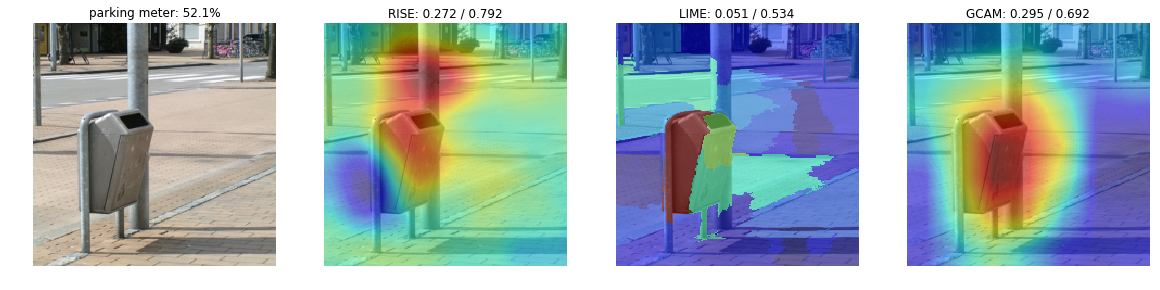

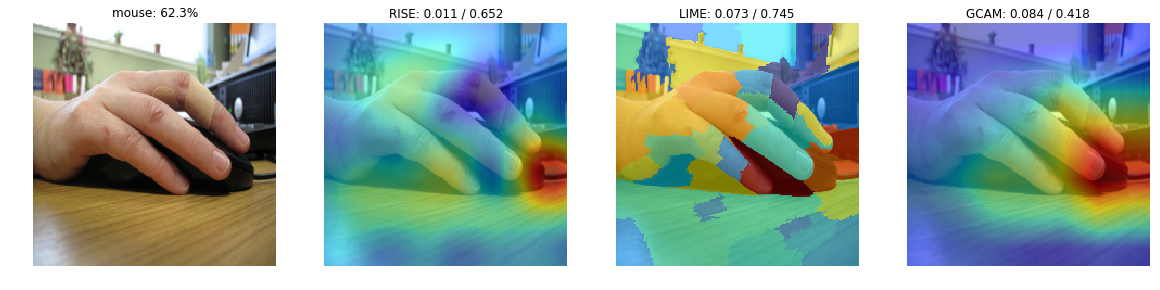

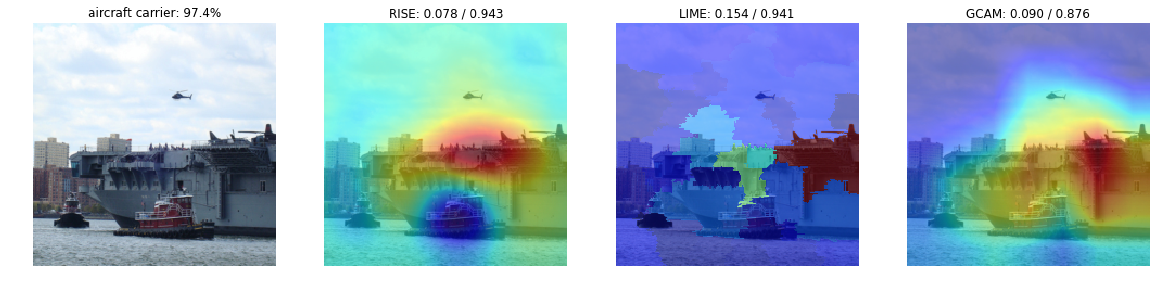

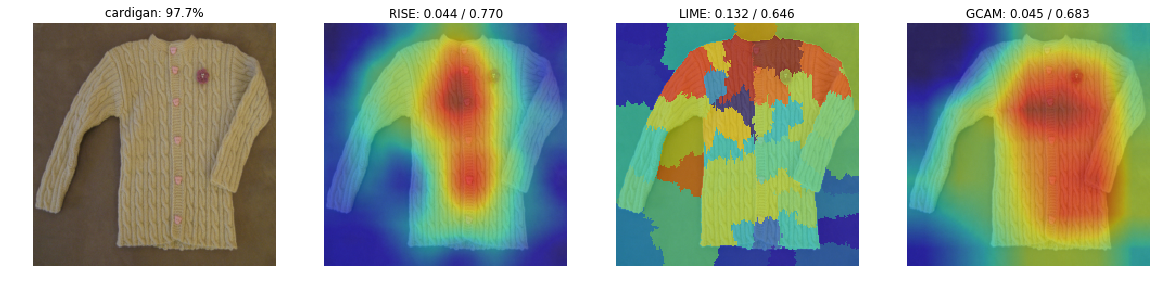

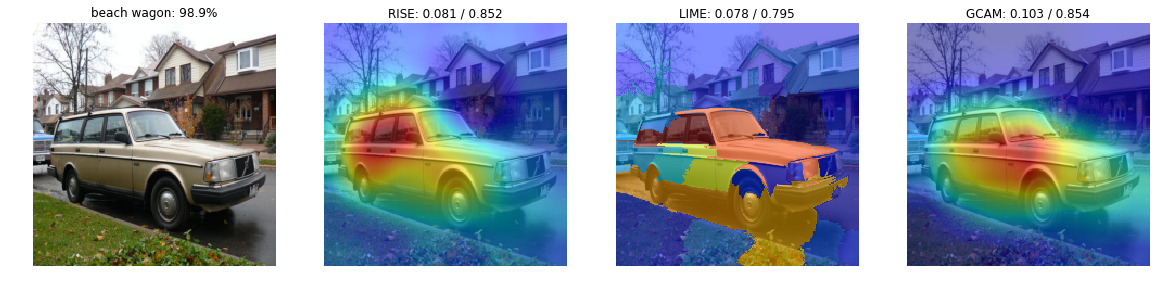

In [ ]:
for j in np.random.randint(0, 5001, 5):
    # Image ID: 5000*batch + j
    show_i(j, gc, rm, li, images)

## Evaluate a batch of explanations

In [ ]:
insertion = CausalMetric(model, 'ins', 224 * 8, substrate_fn=blur)
deletion = CausalMetric(model, 'del', 224 * 8, substrate_fn=torch.zeros_like)

scores = {'del': [], 'ins': []}

for i in range(2):
    # Load batch of images
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=250, shuffle=False,
        num_workers=8, pin_memory=True, sampler=RangeSampler(range(5000 * i, 5000 * (i + 1))))

    images = np.empty((len(data_loader), 250, 3, 224, 224))
    for j, (img, _) in enumerate(tqdm(data_loader, total=len(data_loader), desc='Loading images')):
        images[j] = img
    images = images.reshape((-1, 3, 224, 224))
    # Load saved batch of explanations
    exp = np.fromfile('../random-masking/run02/explanations/exp_{:05}-{:05}.npy'.format(i * 5000, (i + 1) * 5000 - 1)).reshape((5000, 224, 224))

    # Evaluate deletion
    h = deletion.evaluate(torch.from_numpy(images.astype('float32')), exp, 100)
    scores['del'].append(auc(h.mean(1)))

    # Evaluate insertion
    h = insertion.evaluate(torch.from_numpy(images.astype('float32')), exp, 100)
    scores['ins'].append(auc(h.mean(1)))

print('----------------------------------------------------------------')
print('Final:\nDeletion - {:.5f}\nInsertion - {:.5f}'.format(np.mean(scores['del']), np.mean(scores['ins'])))

Deleting  pixels: 100%|██████████| 29/29 [02:23<00:00,  4.95s/it]


AUC: 0.1023703907068502


Loading images:   0%|          | 0/20 [00:00<?, ?it/s]

AUC: 0.7653968451743889


Deleting  pixels: 100%|██████████| 29/29 [02:27<00:00,  5.10s/it]


AUC: 0.10728502709314547


Inserting pixels: 100%|██████████| 29/29 [02:25<00:00,  5.03s/it]


AUC: 0.7784488931898353
----------------------------------------------------------------
Final:
0.10482770889999783
0.7719228691821121
